# 26장 분류

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/python4daml/blob/main/26장.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
import matplotlib.pyplot as plt

#선 두께
plt.rcParams['lines.linewidth'] = 4
#제목 폰트 크기
plt.rcParams['axes.titlesize'] = 16
#축 레이블 폰트 크기
plt.rcParams['axes.labelsize'] = 16
#x 축 텍스트 크기
plt.rcParams['xtick.labelsize'] = 16
#y 축 텍스트 크기
plt.rcParams['ytick.labelsize'] = 16
#x 축 눈금 크기
plt.rcParams['xtick.major.size'] = 7
#y 축 눈금 크기
plt.rcParams['ytick.major.size'] = 7
#마커 크기
plt.rcParams['lines.markersize'] = 10
#범례를 표시할 때 마커 표시 개수
plt.rcParams['legend.numpoints'] = 1
#범례 텍스트 크기
plt.rcParams['legend.fontsize'] = 14

In [2]:
# 코랩에서 실행하는 경우 다음 코드의 주석을 해제하고 실행하세요.
#!wget https://raw.githubusercontent.com/rickiepark/python4daml/main/bm_results2012.csv
#!wget https://raw.githubusercontent.com/rickiepark/python4daml/main/TitanicPassengers.csv

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import random 
import sklearn.linear_model as sklm 
import sklearn.metrics as skm 

## 26.1 분류기 평가하기

그림 26-4 분류기 평가 함수 

In [4]:
def accuracy(true_pos, false_pos, true_neg, false_neg): 
    numerator = true_pos + true_neg 
    denominator = true_pos + true_neg + false_pos + false_neg 
    return numerator/denominator 

def sensitivity(true_pos, false_neg): 
    try: 
        return true_pos/(true_pos + false_neg) 
    except ZeroDivisionError: 
        return float('nan') 

def specificity(true_neg, false_pos): 
    try: 
        return true_neg/(true_neg + false_pos) 
    except ZeroDivisionError: 
        return float('nan') 

def precision(true_pos, false_pos): 
    try: 
        return true_pos/(true_pos + false_pos) 
    except ZeroDivisionError: 
        return float('nan') 

def neg_pred_val(true_neg, false_neg): 
    try: 
        return true_neg/(true_neg + false_neg) 
    except ZeroDivisionError: 
        return float('nan') 

def get_stats(true_pos, false_pos, true_neg, false_neg, 
              toPrint = True): 
    accur = accuracy(true_pos, false_pos, true_neg, false_neg) 
    sens = sensitivity(true_pos, false_neg) 
    spec = specificity(true_neg, false_pos) 
    prec = precision(true_pos, false_pos) 
    if toPrint: 
        print(' 정확도 =', round(accur, 3)) 
        print(' 민감도 =', round(sens, 3)) 
        print(' 특이도 =', round(spec, 3)) 
        print(' 정밀도 =', round(prec, 3)) 
    return (accur, sens, spec, prec) 

## 26.2 달리기 선수의 성별 예측하기

그림 26-6 샘플 집합을 만들고 훈련 세트와 테스트 세트로 나누기

In [5]:
class Runner(object): 
    def __init__(self, name, gender, age, time): 
        self._name = name 
        self._feature_vec = np.array([age, time]) 
        self._label = gender 

    def feature_dist(self, other): 
        return ((self._feature_vec-other._feature_vec)**2).sum()**0.5 

    def get_time(self): 
        return self._feature_vec[1] 

    def get_age(self): 
        return self._feature_vec[0] 

    def get_label(self): 
        return self._label 

    def get_features(self): 
        return self._feature_vec 

    def __str__(self): 
        return (f'{self._name}: {self.get_age()}, ' + 
                f'{self.get_time()}, {self._label}') 

def build_marathon_examples(file_name): 
    df = pd.read_csv(file_name) 
    examples = [] 
    for index, row in df.iterrows(): 
        a = Runner(row['Name'],row['Gender'],row['Age'],row['Time']) 
        examples.append(a) 
    return examples 

def divide_80_20(examples): 
    sample_indices = random.sample(range(len(examples)), 
                                   len(examples)//5) 
    training_set, test_set = [], [] 
    for i in range(len(examples)): 
        if i in sample_indices: 
            test_set.append(examples[i]) 
        else: 
            training_set.append(examples[i]) 
    return training_set, test_set 

## 26.3 K-최근접 이웃

그림 26-7 K-최근접 이웃 찾기

In [6]:
def find_k_nearest(example, example_set, k): 
    k_nearest, distances = [], [] 
    # 처음 k 개의 샘플과 거리를 담은 리스트를 만듭니다
    for i in range(k): 
        k_nearest.append(example_set[i]) 
        distances.append(example.feature_dist(example_set[i])) 
    max_dist = max(distances) #최대 거리를 구합니다
    # 다른 샘플을 조사합니다
    for e in example_set[k:]: 
        dist = example.feature_dist(e) 
        if dist < max_dist: 
            #가장 먼 거리의 샘플을 바꿉니다
            max_index = distances.index(max_dist) 
            k_nearest[max_index] = e 
            distances[max_index] = dist 
            max_dist = max(distances) 
    return k_nearest, distances 

def k_nearest_classify(training_set, test_set, label, k): 
    """training_set & test_set는 샘플의 리스트이고 k는 정수라고 가정합니다.
       k-최근접 이웃 분류기를 사용해 test_set에 있는 샘플의 레이블을 예측합니다.
       진짜 양성, 거짓 양성, 진짜 음성, 거짓 음성을 반환합니다""" 
    true_pos, false_pos, true_neg, false_neg = 0, 0, 0, 0 
    for e in test_set: 
        nearest, distances = find_k_nearest(e, training_set, k) 
        # 투표 
        num_match = 0 
        for i in range(len(nearest)): 
            if nearest[i].get_label() == label: 
                num_match += 1 
        if num_match > k//2: # label이 다수일 때
            if e.get_label() == label: 
                true_pos += 1 
            else: 
                false_pos += 1 
        else: # label이 다수가 아닐 때
            if e.get_label() != label: 
                true_neg += 1 
            else: 
                false_neg += 1 
    return true_pos, false_pos, true_neg, false_neg 

In [7]:
random.seed(0)
examples = build_marathon_examples('bm_results2012.csv') 
training, test_set = divide_80_20(examples) 
true_pos, false_pos, true_neg, false_neg = \
    k_nearest_classify(training, test_set, 'M', 9) 
get_stats(true_pos, false_pos, true_neg, false_neg) 

 정확도 = 0.65
 민감도 = 0.715
 특이도 = 0.563
 정밀도 = 0.684


(0.6497214484679665, 0.7152182782537739, 0.563274098007539, 0.6836973478939158)

그림 26-8 빈도 기반 분류기

In [8]:
def prevalence_classify(training_set, test_set, label): 
    """training_set & test_set는 샘플의 리스트라고 가정합니다.
       빈도 기반 분류기로 test_set에 있는 샘플의 레이블을 예측합니다.
       진짜 양성, 거짓 양성, 진짜 음성, 거짓 음성을 반환합니다""" 
    num_with_label = 0 
    for e in training: 
        if e.get_label()== label: 
            num_with_label += 1 
    prob_label = num_with_label/len(training_set) 
    true_pos, false_pos, true_neg, false_neg = 0, 0, 0, 0 
    for e in test_set: 
        if random.random() < prob_label: #label 확률보다 작을 때
            if e.get_label() == label: 
                true_pos += 1 
            else: 
                false_pos += 1 
        else: #label 확률보다 클 때
            if e.get_label() != label: 
                true_neg += 1 
            else: 
                false_neg += 1 
    return true_pos, false_pos, true_neg, false_neg 

In [9]:
random.seed(0)
examples = build_marathon_examples('bm_results2012.csv') 
training, test_set = divide_80_20(examples) 
true_pos, false_pos, true_neg, false_neg = \
    prevalence_classify(training, test_set, 'M') 
get_stats(true_pos, false_pos, true_neg, false_neg) 

 정확도 = 0.514
 민감도 = 0.593
 특이도 = 0.41
 정밀도 = 0.57


(0.5141597028783659,
 0.5928192574459404,
 0.41033925686591277,
 0.5702511773940345)

In [10]:
random.seed(0)
examples = build_marathon_examples('bm_results2012.csv') 
training, test_set = divide_80_20(examples)
reduced_training = random.sample(training, len(training)//10)
true_pos, false_pos, true_neg, false_neg = \
    k_nearest_classify(reduced_training, test_set, 'M', 9) 
get_stats(true_pos, false_pos, true_neg, false_neg) 

 정확도 = 0.638
 민감도 = 0.667
 특이도 = 0.599
 정밀도 = 0.687


(0.6376508820798514,
 0.6666666666666666,
 0.5993537964458805,
 0.6871320437342304)

그림 26-9 좋은 k 값 찾기

**경고: 이 코드는 실행하는데 오래 걸립니다**

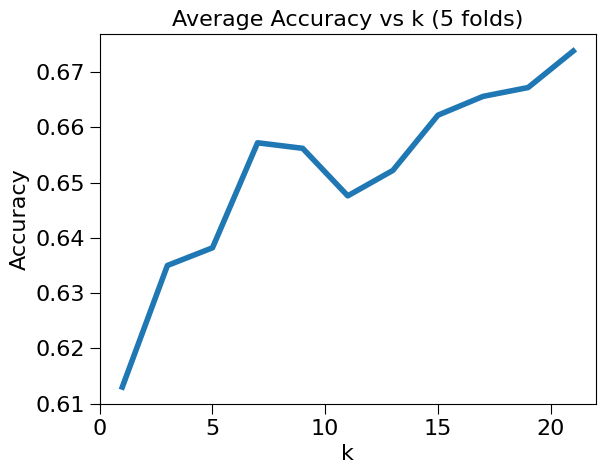

In [11]:
def find_k(training_set, min_k, max_k, num_folds, label): 
    # 홀수 k 값 범위에서 평균 정확도 구하기
    accuracies = [] 
    for k in range(min_k, max_k + 1, 2): 
        score = 0.0 
        for i in range(num_folds): 
            # 계산 시간을 줄이기 위해 다운샘플링하기
            fold = random.sample(training_set, 
                                 min(5000, len(training_set))) 
            examples, test_set = divide_80_20(fold) 
            true_pos, false_pos, true_neg, false_neg = \
                k_nearest_classify(examples, test_set, label, k) 
            score += accuracy(true_pos, false_pos, true_neg, false_neg) 
        accuracies.append(score/num_folds) 
    plt.plot(range(min_k, max_k + 1, 2), accuracies) 
    plt.title('Average Accuracy vs k (' + str(num_folds) \
              + ' folds)') 
    plt.xlabel('k') 
    plt.ylabel('Accuracy') 

find_k(training, 1, 21, 5, 'M') 

## 26.4 회귀 기반 분류기

In [12]:
random.seed(0)
examples = build_marathon_examples('bm_results2012.csv')
training, test_set = divide_80_20(examples)

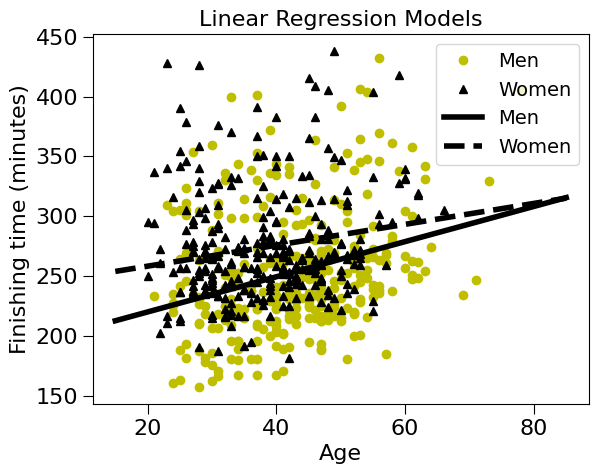

In [13]:
# 남자와 여자를 위한 훈련 세트를 만듭니다
age_m, age_w, time_m, time_w = [], [], [], [] 
for e in training: 
    if e.get_label() == 'M': 
        age_m.append(e.get_age()) 
        time_m.append(e.get_time()) 
    else: 
        age_w.append(e.get_age()) 
        time_w.append(e.get_time()) 
# 보기 쉬운 그래프를 위해 다운 샘플링합니다
ages, times = [], [] 
for i in random.sample(range(len(age_m)), 300): 
    ages.append(age_m[i]) 
    times.append(time_m[i]) 
# 산점도를 그립니다
plt.plot(ages, times, 'yo', markersize = 6, label = 'Men') 
ages, times = [], [] 
for i in random.sample(range(len(age_w)), 300): 
    ages.append(age_w[i]) 
    times.append(time_w[i]) 
plt.plot(ages, times, 'k^', markersize = 6, label = 'Women') 
# 두 개의 2차 선형 회귀 모델 훈련합니다
m_model = np.polyfit(age_m, time_m, 1) 
f_model = np.polyfit(age_w, time_w, 1) 
#모델에 상응하는 직선을 그립니다
xmin, xmax = 15, 85 
plt.plot((xmin, xmax), (np.polyval(m_model,(xmin, xmax))), 
         'k', label = 'Men') 
plt.plot((xmin, xmax), (np.polyval(f_model,(xmin, xmax))), 
         'k--', label = 'Women') 
plt.title('Linear Regression Models') 
plt.xlabel('Age') 
plt.ylabel('Finishing time (minutes)') 
plt.legend()

그림 26-13 선형 회귀를 사용하여 분류기 만들기 

In [14]:
true_pos, false_pos, true_neg, false_neg = 0, 0, 0, 0 
for e in test_set: 
    age = e.get_age() 
    time = e.get_time() 
    if (abs(time -np.polyval(m_model,age)) < 
        abs(time -np.polyval(f_model, age))): 
        if e.get_label() == 'M': 
            true_pos += 1 
        else: 
            false_pos += 1 
    else: 
        if e.get_label() == 'F': 
            true_neg += 1 
        else: 
            false_neg += 1 
get_stats(true_pos, false_pos, true_neg, false_neg) 

 정확도 = 0.614
 민감도 = 0.684
 특이도 = 0.523
 정밀도 = 0.654


(0.6144382544103992,
 0.6838025295797634,
 0.5228863758750674,
 0.6541764246682279)

그림 26-14 sklearn을 사용하여 다중 클래스 로지스틱 회귀 수행하기

In [15]:
random.seed(0)

feature_vecs, labels = [], [] 
for i in range(25000): # create 4 examples in each iteration 
    feature_vecs.append([random.gauss(0, 0.5), random.gauss(0, 0.5), 
                         random.random()]) 
    labels.append('A') 
    feature_vecs.append([random.gauss(0, 0.5), random.gauss(2, 0.), 
                         random.random()]) 
    labels.append('B') 
    feature_vecs.append([random.gauss(2, 0.5), random.gauss(0, 0.5), 
                         random.random()]) 
    labels.append('C') 
    feature_vecs.append([random.gauss(2, 0.5), random.gauss(2, 0.5), 
                         random.random()]) 
    labels.append('D') 

model = sklm.LogisticRegression().fit(feature_vecs, labels) 
print('model.classes_ =', model.classes_) 

for i in range(len(model.coef_)): 
    print('레이블', model.classes_[i], 
          '의 특성 가중치 =', model.coef_[i].round(4)) 

print('[0, 0]의 확률 =', model.predict_proba([[0, 0, 1]])[0].round(4)) 
print('[0, 2]의 확률 =', model.predict_proba([[0, 2, 2]])[0].round(4)) 
print('[2, 0]의 확률 =', model.predict_proba([[2, 0, 3]])[0].round(4)) 
print('[2, 2]의 확률 =', model.predict_proba([[2, 2, 4]])[0].round(4)) 

model.classes_ = ['A' 'B' 'C' 'D']
레이블 A 의 특성 가중치 = [-4.7229 -4.3618  0.0595]
레이블 B 의 특성 가중치 = [-3.3346  4.7875  0.0149]
레이블 C 의 특성 가중치 = [ 3.7026 -4.4966 -0.0176]
레이블 D 의 특성 가중치 = [ 4.3548  4.0709 -0.0568]
[0, 0]의 확률 = [9.998e-01 0.000e+00 2.000e-04 0.000e+00]
[0, 2]의 확률 = [2.60e-03 9.97e-01 0.00e+00 4.00e-04]
[2, 0]의 확률 = [3.000e-04 0.000e+00 9.996e-01 2.000e-04]
[2, 2]의 확률 = [0.000e+00 5.000e-04 2.000e-04 9.992e-01]


그림 26-15 이진 분류를 위한 로지스틱 회귀

In [16]:
random.seed(0)

feature_vecs, labels = [], [] 
for i in range(20000): 
    feature_vecs.append([random.gauss(0, 0.5), random.gauss(0, 0.5)]) 
    labels.append('A') 
    feature_vecs.append([random.gauss(2, 0.5), random.gauss(2, 0.5)]) 
    labels.append('D') 

model = sklm.LogisticRegression().fit(feature_vecs, labels) 
print('model.coef =', model.coef_.round(4)) 
print('[0, 0]의 확률 =', model.predict_proba([[0, 0]])[0].round(4)) 
print('[0, 2]의 확률 =', model.predict_proba([[0, 2]])[0].round(4)) 
print('[2, 0]의 확률 =', model.predict_proba([[2, 0]])[0].round(4)) 
print('[2, 2]의 확률 =', model.predict_proba([[2, 2]])[0].round(4)) 

model.coef = [[6.7081 6.5737]]
[0, 0]의 확률 = [1. 0.]
[0, 2]의 확률 = [0.5354 0.4646]
[2, 0]의 확률 = [0.4683 0.5317]
[2, 2]의 확률 = [0. 1.]


그림 26-16 로지스틱 회귀를 사용하여 성별 예측하기

In [17]:
def apply_model(model, test_set, label, prob = 0.5): 
    # 모든 테스트 샘플의 특성 벡터를 담은 리스트를 만듭니다
    test_feature_vecs = [e.get_features() for e in test_set] 
    probs = model.predict_proba(test_feature_vecs) 
    true_pos, false_pos, true_neg, false_neg = 0, 0, 0, 0 
    for i in range(len(probs)): 
        if probs[i][1] > prob: 
            if test_set[i].get_label() == label: 
                true_pos += 1 
            else: 
                false_pos += 1 
        else: 
            if test_set[i].get_label() != label: 
                true_neg += 1 
            else: 
                false_neg += 1 
    return true_pos, false_pos, true_neg, false_neg 

random.seed(0)

examples = build_marathon_examples('bm_results2012.csv') 
training, test = divide_80_20(examples) 

feature_vecs, labels = [], [] 
for e in training: 
    feature_vecs.append([e.get_age(), e.get_time()]) 
    labels.append(e.get_label()) 
model = sklm.LogisticRegression().fit(feature_vecs,labels) 
print('레이블 M에 대한 특성 가중치:', 
      '나이 =', str(round(model.coef_[0][0], 3)) + ',', 
      '시간 =', round(model.coef_[0][1], 3)) 
true_pos, false_pos, true_neg, false_neg = \
    apply_model(model, test, 'M', 0.5) 
get_stats(true_pos, false_pos, true_neg, false_neg) 

레이블 M에 대한 특성 가중치: 나이 = 0.055, 시간 = -0.011
 정확도 = 0.636
 민감도 = 0.831
 특이도 = 0.377
 정밀도 = 0.638


(0.6355617455896008,
 0.8310893512851897,
 0.3774905761981691,
 0.6379580331976198)

In [18]:
true_pos, false_pos, true_neg, false_neg = \
    apply_model(model, test, 'M', 0.578) 
get_stats(true_pos, false_pos, true_neg, false_neg) 

 정확도 = 0.659
 민감도 = 0.715
 특이도 = 0.586
 정밀도 = 0.695


(0.6594707520891365,
 0.7152182782537739,
 0.5858912224017232,
 0.6950832672482157)

그림 26-17 ROC 곡선과 AUROC 계산하기

0.7019385008086333

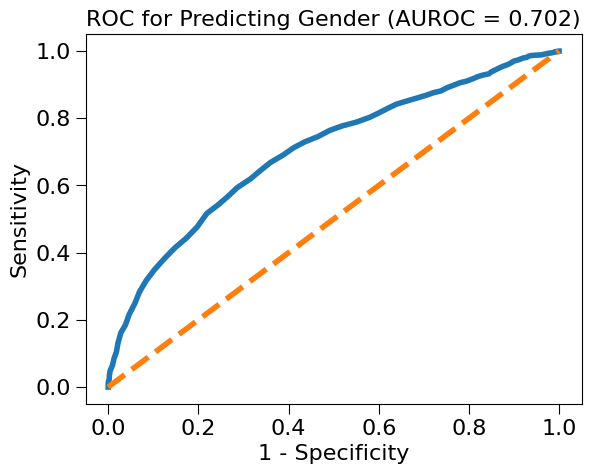

In [19]:
def build_ROC(model, test_set, label, title, plot = True): 
    xVals, yVals = [], [] 
    for p in np.arange(0, 1, 0.01): 
        true_pos, false_pos, true_neg, false_neg = \
            apply_model(model, test_set, label, p) 
        xVals.append(1.0 - specificity(true_neg, false_pos)) 
        yVals.append(sensitivity(true_pos, false_neg)) 
    auroc = skm.auc(xVals, yVals) 
    if plot: 
        plt.plot(xVals, yVals) 
        plt.plot([0,1], [0,1,], '--') 
        plt.title(title + ' (AUROC = ' + 
                  str(round(auroc, 3)) + ')') 
        plt.xlabel('1 - Specificity') 
        plt.ylabel('Sensitivity') 
    return auroc 

build_ROC(model, test, 'M', 'ROC for Predicting Gender') 

**손가락 운동**

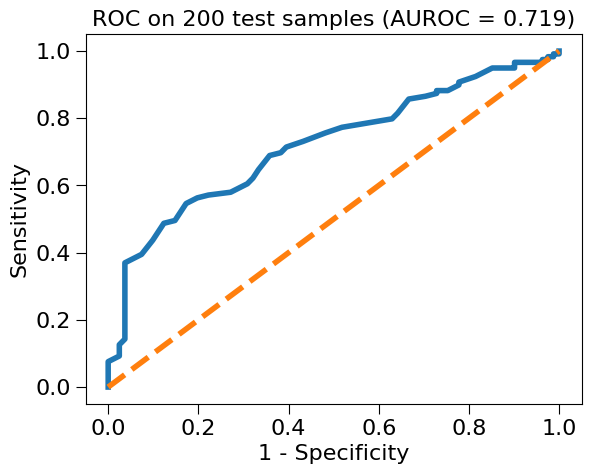

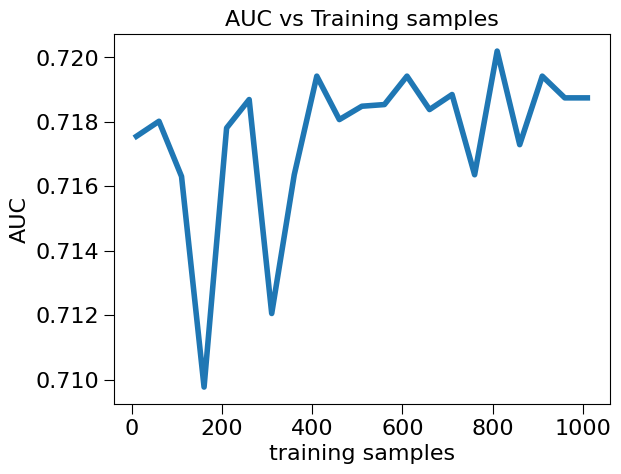

In [20]:
random.seed(0)
test_runner = random.sample(test, 200)
build_ROC(model, test_runner, 'M', 'ROC on 200 test samples') 
plt.show()

aucs = []
for n in range(10, 1011, 50):
    training_sample = random.sample(training, n)
    feature_vecs, labels = [], [] 
    for e in training_sample: 
        feature_vecs.append([e.get_age(), e.get_time()]) 
        labels.append(e.get_label()) 
    m = sklm.LogisticRegression().fit(feature_vecs,labels) 
    aucs.append(build_ROC(m, test_runner, 'M', f'ROC on {n} training samples', plot=False))

plt.plot(range(10, 1011, 50), aucs)
plt.xlabel('training samples')
plt.ylabel('AUC')
plt.title('AUC vs Training samples')
plt.show()

## 26.5 타이타닉 생존자 예측하기

In [21]:
manifest = pd.read_csv('TitanicPassengers.csv') 
print(manifest.corr().round(2)) 

          Class   Age  Survived
Class      1.00 -0.41     -0.32
Age       -0.41  1.00     -0.06
Survived  -0.32 -0.06      1.00


In [22]:
manifest['Gender'] = (manifest['Gender']. 
                      apply(lambda g: 1 if g == 'M' else 0)) 
print(manifest.corr().round(2)) 

          Class   Age  Gender  Survived
Class      1.00 -0.41    0.14     -0.32
Age       -0.41  1.00    0.06     -0.06
Gender     0.14  0.06    1.00     -0.54
Survived  -0.32 -0.06   -0.54      1.00


그림 26-19 `Passenger` 클래스

In [23]:
class Passenger(object): 
    features = ('1st Class', '2nd Class', '3rd Class', 
                'age', 'male') 
    def __init__(self, pClass, age, gender, survived, name): 
        self.name = name 
        self.feature_vec = [0, 0, 0, age, gender] 
        self.feature_vec[pClass -1] = 1 
        self.label = survived 
        self.cabinClass = pClass 
    def distance(self, other): 
        return minkowski_dist(self.veatureVec, other.feature_vec, 2) 
    def get_class(self): 
        return self.cabinClass 
    def get_age(self): 
        return self.feature_vec[3] 
    def get_gender(self): 
        return self.feature_vec[4] 
    def get_name(self): 
        return self.name 
    def get_features(self): 
        return self.feature_vec[:] 
    def get_label(self): 
        return self.label 

그림 26-20 타이타닉 데이터를 읽고 샘플 리스트 만들기

In [24]:
def build_Titanic_examples(): 
    manifest = pd.read_csv('TitanicPassengers.csv') 
    examples = [] 
    for index, row in manifest.iterrows(): 
        p = Passenger(row['Class'], row['Age'], 
                      1 if row['Gender'] == 'M' else 0, 
                      row['Survived'], 
                      row['Last Name'] + row['Other Names']) 
        examples.append(p) 
    return examples 

그림 26-21 타이타닉 모델 테스트하기

In [25]:
def test_models(examples, num_trials, print_stats, print_weights): 
    stats, weights = [], [[], [], [], [], []] 
    for i in range(num_trials): 
        training, test_set = divide_80_20(examples) 
        xVals, yVals = [], [] 
        for e in training: 
            xVals.append(e.get_features()) 
            yVals.append(e.get_label()) 
        xVals = np.array(xVals) 
        yVals = np.array(yVals) 
        model = sklm.LogisticRegression().fit(xVals, yVals) 
        for i in range(len(Passenger.features)): 
            weights[i].append(model.coef_[0][i]) 
        true_pos, false_pos, true_neg, false_neg = \
            apply_model(model, test_set, 1, 0.5) 
        auroc = build_ROC(model, test_set, 1, None, False) 
        tmp = get_stats(true_pos, false_pos, true_neg, false_neg, False) 
        stats.append(tmp + (auroc,)) 
    print(num_trials, '시도의 평균') 
    if print_weights: 
        for feature in range(len(weights)): 
            feature_mean = round(sum(weights[feature])/num_trials, 3) 
            feature_std = np.std(weights[feature]) 
            print(' 평균 가중치', Passenger.features[feature], 
                  '=', str(feature_mean) + ', 95% 신뢰 구간 =', 
                  round(feature_mean - 1.96*feature_std, 3), 'to', 
                  round(feature_mean + 1.96*feature_std, 3)) 
    if print_stats: 
        summarize_stats(stats) 

그림 26-22 분류 모델의 통계량 출력하기

In [26]:
def summarize_stats(stats): 
    """stats는5 개의 실수(정확도, 민감도, 특이도, 정밀도, AUC)로
       구성된 리스트라고 가정합니다""" 
    def print_stat(X, name): 
        mean = round(sum(X)/len(X), 3) 
        std = np.std(X) 
        print(' 평균', name, '=', str(mean) + ',', 
              '95% 신뢰 구간 =', 
              round(mean - 1.96*std, 3), 'to', 
              round(mean + 1.96*std, 3)) 
    accs, sens, specs, precs, aurocs = [], [], [], [], [] 
    for stat in stats: 
        accs.append(stat[0]) 
        sens.append(stat[1]) 
        specs.append(stat[2]) 
        precs.append(stat[3]) 
        aurocs.append(stat[4]) 
    print_stat(accs, '정확도') 
    print_stat(sens, '민감도') 
    print_stat(accs, '특이도')
    print_stat(precs, '정밀도') 
    print_stat(aurocs, 'AUC') 

In [27]:
random.seed(0)
test_models(build_Titanic_examples(), 100, True, False)

100 시도의 평균
 평균 정확도 = 0.783, 95% 신뢰 구간 = 0.736 to 0.83
 평균 민감도 = 0.702, 95% 신뢰 구간 = 0.603 to 0.801
 평균 특이도 = 0.783, 95% 신뢰 구간 = 0.736 to 0.83
 평균 정밀도 = 0.752, 95% 신뢰 구간 = 0.664 to 0.84
 평균 AUC = 0.839, 95% 신뢰 구간 = 0.789 to 0.889


In [28]:
random.seed(0)
test_models(build_Titanic_examples(), 100, False, True)

100 시도의 평균
 평균 가중치 1st Class = 1.145, 95% 신뢰 구간 = 1.02 to 1.27
 평균 가중치 2nd Class = -0.083, 95% 신뢰 구간 = -0.185 to 0.019
 평균 가중치 3rd Class = -1.062, 95% 신뢰 구간 = -1.179 to -0.945
 평균 가중치 age = -0.034, 95% 신뢰 구간 = -0.04 to -0.028
 평균 가중치 male = -2.404, 95% 신뢰 구간 = -2.542 to -2.266
